# **This implementation executes the results of the CIFER10 part for the part 2 of the lab. The results of this implementation is compared with the results of the mentioned paper, and interesting findings are discussed.**

In [1]:
# Run this cell only if tensorflow 2.0 needs to be installed, otherwise please ignore this cell.

#!pip install tensorflow-gpu==2.0.0-beta1

**The CIFER10 Dataset is loaded, shuffled and normalized.**

In [2]:
import tensorflow as tf
import numpy
from sklearn.utils import shuffle

# Getting the dataset and normalizing.
cifer10 = tf.compat.v2.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifer10.load_data()
x_train = x_train/255.0; x_test = x_test/255.0

/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework

**After normalization of the input data, it is time to define the architectures of the models. In the paper, two models were mentioned, each consisting of 3 5x5 convolution filters followed by 3x3 maxpooling layers with 2 strides, with channels as 64, 64, 128 respectively. For one model dropouts were added after input layer and the fully connected layer of 1000 unit. A, the dropout's probability was not mentioned, thus, for my experiments I have considered the dropout probabilities to be 0.5.**

In [3]:
# Calling necessary modules essential for the implementation of the model.
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras import Model

# The return function, when called, will return object of the model.
# Defining the Model with Dropouts
def return_Model_withDropout():
  
  # Extending the model class.
  class Model_CIFER10_Dropout(Model):
    def __init__(self):
      super(Model_CIFER10_Dropout, self).__init__()
      # Define layers.
      self.conv1 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')
      self.maxpool1 = MaxPool2D((3,3),strides=2,padding='same')
      self.conv2 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')
      self.maxpool2 = MaxPool2D((3,3),strides=2,padding='same')
      self.conv3 = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')
      self.maxpool3 = MaxPool2D((3,3),strides=2,padding='same')
      self.hidden = Dense(1000, activation='relu')
      self.flatten = Flatten()
      self.dropout = Dropout(0.5)
      self.final = Dense(10, activation='softmax')

    # Assigning the forward pass.
    def call(self, x):
      x = self.dropout(x)
      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool2(x)
      x = self.conv3(x)
      x = self.maxpool3(x)
      x = self.flatten(x)
      x = self.hidden(x)
      x = self.dropout(x)
      x = self.final(x)
      return x
  
  # Creating the object of the model and returning the same.
  model_cifer10_dropout = Model_CIFER10_Dropout()
  return(model_cifer10_dropout)

In [4]:
# Defining the Model without Dropouts
def return_Model_withoutDropout():
  
  # Extending the model class.
  class Model_CIFER10(Model):
    def __init__(self):
      super(Model_CIFER10, self).__init__()
      # Define layers.
      self.conv1 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')
      self.maxpool1 = MaxPool2D((3,3),strides=2,padding='same')
      self.conv2 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')
      self.maxpool2 = MaxPool2D((3,3),strides=2,padding='same')
      self.conv3 = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')
      self.maxpool3 = MaxPool2D((3,3),strides=2,padding='same')
      self.hidden = Dense(1000, activation='relu')
      self.flatten = Flatten()
      self.dropout = Dropout(0.5)
      self.final = Dense(10, activation='softmax')

    # Assigning the forward pass.
    def call(self, x):

      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool2(x)
      x = self.conv3(x)
      x = self.maxpool3(x)
      x = self.flatten(x)
      x = self.hidden(x)
      x = self.final(x)
      return x
  
  # Creating the object of the model and returning the same.
  model_cifer10 = Model_CIFER10()
  return(model_cifer10)

**After the defining the network architecture, it is time to create our own optimizers. For making the code more efficient the abtract optimizer class have been extended. The benefit of this method lies with the fact that since the custom optimizers are extended for the abstract class, it becomes much easier to handle the gradients from the call-graph and weight updates. In the paper three different optimizers were used for comparison, which include SGD with Nesterov's Momentum, AdaGrad and Adam.**

In [5]:
# Calling necessary modules for implemnetation of the a proper custom optimizer.
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer

**The first implemntation is SGD with Nesterov's Momentum optimizer.**

In [6]:
# The SGDNesterov Optimizer class have been defined.
class MySGDNesterov(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, gamma=0.9, use_locking=False, name="MySGDNesterov"):
      
      super(MySGDNesterov, self).__init__(use_locking, name)
      
      # Defining the class member function's essential for the optimization
      self._lr = learning_rate; self._gamma = gamma;
      self._lr_t = None; self._gamma_t = None;

    # prepare(), create_slots() and resourse_apply_dense() are member functions that are declared in the base class.
    # These functions allow efficient gathering of the weights and the grad values from the accumulate of the running device,
    # as well has element update implementation.
    
    # The prepare function prepares class members to be operable for executing in the call-graph.
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._gamma_t = ops.convert_to_tensor(self._gamma)

    # This function creates slots with running variables in the accumulator, i.e., variables other than the weights whose values are going to change
    # in each iteration, and initialize their values as zero.
    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "mt", self._name)

    # The resource_apply_dense functions computes the updated values of the weights, and updates the same alongside the running variables
    # in thr accumulator.
    def _resource_apply_dense(self, grad, var):
      
      # Type casting for data members for calculation.
      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)
      
      # The function get_slot gets the current value of the running variable.
      mt_old = self.get_slot(var, "mt")
      mt = mt_old.assign(gamma_t * mt_old + lr_t * grad)
      
      # Updates the weights' values.
      update_val = (-gamma_t * mt_old) + ((1 + gamma_t) * mt)
      var_update = state_ops.assign_sub(var, update_val)
      
      # Updates the new values of the weights and the running variables to the accumulator.
      return control_flow_ops.group(*[var_update,mt])

**Implementation of Adagrad optimizer.**

In [7]:
class MyAdagrad(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, epsilon=1e-8, use_locking=False, name="MyAdagrad"):
      
      super(MyAdagrad, self).__init__(use_locking, name)
      
      self._lr = learning_rate; self._epsilon = epsilon
      self._lr_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "vt", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the value of the adaptive velocity.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign(vt + tf.square(grad))

      # Final weight update equation and updating the weights.
      update_val = (lr_t * grad) / tf.sqrt(vt_new + epsilon_t)
      var_update = state_ops.assign_sub(var, update_val)

      return control_flow_ops.group(*[var_update,vt_new])

**Implementation of Adam optimizer.**

In [8]:
class MyAdam(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, gamma=0.9, beta = 0.999, epsilon=1e-8, use_locking=False, name="MyAdam"):
      
      super(MyAdam, self).__init__(use_locking, name)
      
      self._lr = learning_rate; self._gamma = gamma; self._beta = beta; self._epsilon = epsilon
      self._lr_t = None; self._gamma_t = None; self._beta_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._gamma_t = ops.convert_to_tensor(self._gamma)
      self._beta_t = ops.convert_to_tensor(self._beta)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "mt", self._name)
        self._zeros_slot(v, "vt", self._name)
        self._zeros_slot(v, "t", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)
      beta_t = math_ops.cast(self._beta_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the updated t value required for correction.
      t = self.get_slot(var, "t")
      t_new = t + 1
      
      # Getting the moment value and calculating the corrected updated value.
      mt = self.get_slot(var, "mt")
      mt_new = mt.assign((gamma_t * mt) + ((1 - gamma_t) * grad))
      corr_mt_new = mt_new / (1-tf.pow(gamma_t,t_new))

      # Getting the velocity value and calculating the corrected updated value.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign((beta_t * vt) + ((1 - beta_t) * tf.square(grad)))
      corr_vt_new = vt_new / (1-tf.pow(beta_t,t_new))

      # Updating weights based on the final update equation.
      update_val = (lr_t * corr_mt_new) / tf.sqrt(corr_vt_new + epsilon_t)

      var_update = state_ops.assign_sub(var, update_val)
      return control_flow_ops.group(*[var_update,mt_new,vt_new,t_new])

**After defining the optimizers I have defined the function calculate_grad(), upon which the final call-graphs will be created. The creation of the call-graph makes the execution much much faster. The purpose of the function is to calculate the gradient, and inside the function the optimizer is called to backpropagate the error and update the weights. This function is wrapped with 'tf.function()', so that, on different instance of the call graph.**

In [9]:
def calculate_grad(model,loss_criterion, x, y, optimizerObj, global_step):
  # tf.GradientTape() calculates the gradient of the los with respect to the weights.
  with tf.GradientTape() as tape:
    # For the prediction, loss is being calculated.
    predictions = model(x)
    loss_value = loss_criterion(y,predictions)
  # Gradient for the loss is also calculated.
  gradients = tape.gradient(loss_value, model.trainable_variables)
  # The optimizer is called to optimize the weights with respect to the gradients.
  optimizerObj.apply_gradients(zip(gradients, model.trainable_variables),global_step)
  return loss_value

**Finally, we define the train_model(), this function is called each time when an optimizer's performance needs to be checked. This functions trains the model based on the chosen optimizer for the two models, and returns the losses and accuracies per epoch for the training.**

In [10]:
def train_model(model,optimizerObj,train_dataset,loss_criterion,global_step,n_epochs,batch_size):

  loss_per_epoch = []
  accuracy_per_epoch = []

  # Wrapping the calculate_grad() to generate the call-graph.
  graph_calculate_grad = tf.function(calculate_grad)

  # Computation for each epoch.
  for epoch in range(n_epochs):
    
    # These two are helper functions to calcuate the running mean of loss, and accuracy.
    epoch_loss = tf.keras.metrics.Mean(name='epoch_loss')
    epoch_accuracy =  tf.keras.metrics.SparseCategoricalAccuracy(name='epoch_accuracy')

    # Computation for each mini-batch.
    for x, y in train_dataset:
      
      # The call-graph for is called. The loss is calculated, the gradients of losses with respect to the weights
      # are generated, and the optimizer optimizes the weights.
      #loss_amount = calculate_grad(model,loss_criterion,x,y,optimizerObj,global_step)
      loss_amount = graph_calculate_grad(model,loss_criterion,x,y,optimizerObj,global_step)
      # Prediction for accuracy.
      predictions = model(x)

      # Calculate the loss and accuracy per epoch.
      epoch_loss(loss_amount)
      epoch_accuracy(y,predictions)

    loss_per_epoch.append(epoch_loss.result())
    accuracy_per_epoch.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.5f}, Accuracy: {:.3%}".format(epoch+1, epoch_loss.result(), epoch_accuracy.result()))

  # The losses and accuracies are returned.
  return(loss_per_epoch,accuracy_per_epoch)

**Since, neural networks depends on multiple random initializations, a single trial is not expressive enough for estimating the performance. However, due to time constrant I have done 1 trials. These values were used to plot the graphs.**

**Note: Plot for accuries were not the part of the results in the paper, however, it still shown as a part of my experiment.**

In [11]:
n_trials = 1

# Number of epochs & batch size have been taken as 5 (due to limited time) and 128 respectively, as given in the paper.
n_epochs = 5
batch_size = 128
# Since learning rate was not mention, it was observed, that 1e-3 is a good choice, and was taken.
lr = 1e-3

loss_sgdNesterov_dropout = numpy.zeros((n_trials,n_epochs))
accuracy_sgdNesterov_dropout = numpy.zeros((n_trials,n_epochs))

loss_sgdNesterov = numpy.zeros((n_trials,n_epochs))
accuracy_sgdNesterov = numpy.zeros((n_trials,n_epochs))

loss_adagrad_dropout = numpy.zeros((n_trials,n_epochs))
accuracy_adagrad_dropout = numpy.zeros((n_trials,n_epochs))

loss_adagrad = numpy.zeros((n_trials,n_epochs))
accuracy_adagrad = numpy.zeros((n_trials,n_epochs))

loss_adam_dropout = numpy.zeros((n_trials,n_epochs))
accuracy_adam_dropout = numpy.zeros((n_trials,n_epochs))

loss_adam = numpy.zeros((n_trials,n_epochs))
accuracy_adam = numpy.zeros((n_trials,n_epochs))

# The train dataset iterator was created.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(batch_size)
# The loss was defined.
loss_criterion = tf.keras.losses.SparseCategoricalCrossentropy()

# The optimizers were declared.
optimizerObj_SGDNesterov = MySGDNesterov(learning_rate=lr)
optimizerObj_Adagrad = MyAdagrad(learning_rate=lr)
optimizerObj_Adam = MyAdam(learning_rate=lr, gamma=0.9, beta = 0.999)

# Performance of each optimizer was observed for each trial
for i in range(n_trials):
  
  print('Trial ' + str(i+1))

  #SGDNesterov with Dropouts
  print('SGD Nesterov With Dropouts')
  model = return_Model_withDropout()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_SGDNesterov,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_sgdNesterov_dropout[i] = numpy.array(loss_per_epoch)
  accuracy_sgdNesterov_dropout[i] = numpy.array(accuracy_per_epoch)

  #SGDNesterov without Dropouts
  print('SGD Nesterov Without Dropouts')
  model = return_Model_withoutDropout()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_SGDNesterov,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_sgdNesterov[i] = numpy.array(loss_per_epoch)
  accuracy_sgdNesterov[i] = numpy.array(accuracy_per_epoch)

  #Adagrad with Dropouts
  print('Adagrad with Dropouts')
  model = return_Model_withDropout()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adagrad,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_adagrad_dropout[i] = numpy.array(loss_per_epoch)
  accuracy_adagrad_dropout[i] = numpy.array(accuracy_per_epoch)

  #Adagrad without Dropouts
  print('Adagrad without Dropouts')
  model = return_Model_withoutDropout()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adagrad,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_adagrad[i] = numpy.array(loss_per_epoch)
  accuracy_adagrad[i] = numpy.array(accuracy_per_epoch)

  #Adam with Dropouts
  print('Adam with Dropouts')
  model = return_Model_withDropout()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adam,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_adam_dropout[i] = numpy.array(loss_per_epoch)
  accuracy_adam_dropout[i] = numpy.array(accuracy_per_epoch)

    #Adam with Dropouts
  print('Adam with Dropouts')
  model = return_Model_withDropout()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adam,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_adam[i] = numpy.array(loss_per_epoch)
  accuracy_adam[i] = numpy.array(accuracy_per_epoch)


Trial 1
SGD Nesterov With Dropouts
Epoch 001: Loss: 2.15198, Accuracy: 22.312%
Epoch 002: Loss: 1.78591, Accuracy: 36.412%
Epoch 003: Loss: 1.59702, Accuracy: 43.042%
Epoch 004: Loss: 1.48332, Accuracy: 47.146%
Epoch 005: Loss: 1.39747, Accuracy: 50.820%
SGD Nesterov Without Dropouts


Epoch 001: Loss: 2.18248, Accuracy: 21.364%
Epoch 002: Loss: 1.81526, Accuracy: 35.160%
Epoch 003: Loss: 1.61016, Accuracy: 42.466%
Epoch 004: Loss: 1.49367, Accuracy: 46.912%
Epoch 005: Loss: 1.40918, Accuracy: 50.384%
Adagrad with Dropouts


Epoch 001: Loss: 1.69978, Accuracy: 42.224%
Epoch 002: Loss: 1.40838, Accuracy: 52.566%
Epoch 003: Loss: 1.31473, Accuracy: 55.988%
Epoch 004: Loss: 1.25467, Accuracy: 58.380%
Epoch 005: Loss: 1.20943, Accuracy: 60.070%
Adagrad without Dropouts


Epoch 001: Loss: 1.70738, Accuracy: 41.682%
Epoch 002: Loss: 1.39606, Accuracy: 53.044%
Epoch 003: Loss: 1.29372, Accuracy: 56.886%
Epoch 004: Loss: 1.22767, Accuracy: 59.478%
Epoch 005: Loss: 1.17946, Accuracy: 61.222%
Adam with Dropouts


Epoch 001: Loss: 1.56544, Accuracy: 43.560%
Epoch 002: Loss: 1.15633, Accuracy: 59.712%
Epoch 003: Loss: 0.99845, Accuracy: 65.926%
Epoch 004: Loss: 0.89769, Accuracy: 69.632%
Epoch 005: Loss: 0.81907, Accuracy: 72.228%
Adam with Dropouts


Epoch 001: Loss: 1.65976, Accuracy: 39.740%
Epoch 002: Loss: 1.27598, Accuracy: 54.882%
Epoch 003: Loss: 1.11342, Accuracy: 61.456%
Epoch 004: Loss: 1.00998, Accuracy: 65.468%
Epoch 005: Loss: 0.93280, Accuracy: 68.202%


**After gathering the training losses, it is time to plot. The losses per epoch for all the trials were averaged first.**

In [12]:
#loss_sgdNesterov_dropout = numpy.mean(loss_sgdNesterov_dropout,axis=0)
#accuracy_sgdNesterov_dropout = numpy.mean(accuracy_sgdNesterov_dropout,axis=0)

#loss_sgdNesterov = numpy.mean(loss_sgdNesterov,axis=0)
#accuracy_sgdNesterov = numpy.mean(accuracy_sgdNesterov,axis=0)

#loss_adagrad_dropout = numpy.mean(loss_adagrad_dropout,axis=0)
#accuracy_adagrad_dropout = numpy.mean(accuracy_adagrad_dropout,axis=0)

#loss_adagrad = numpy.mean(loss_adagrad,axis=0)
#accuracy_adagrad = numpy.mean(accuracy_adagrad,axis=0)

#loss_adam_dropout = numpy.mean(loss_adam_dropout,axis=0)
#accuracy_adam_dropout = numpy.mean(accuracy_adam_dropout,axis=0)

#loss_adam = numpy.mean(loss_adam,axis=0)
#accuracy_adam = numpy.mean(accuracy_adam,axis=0)

**Plot for loss for different optimizers.**

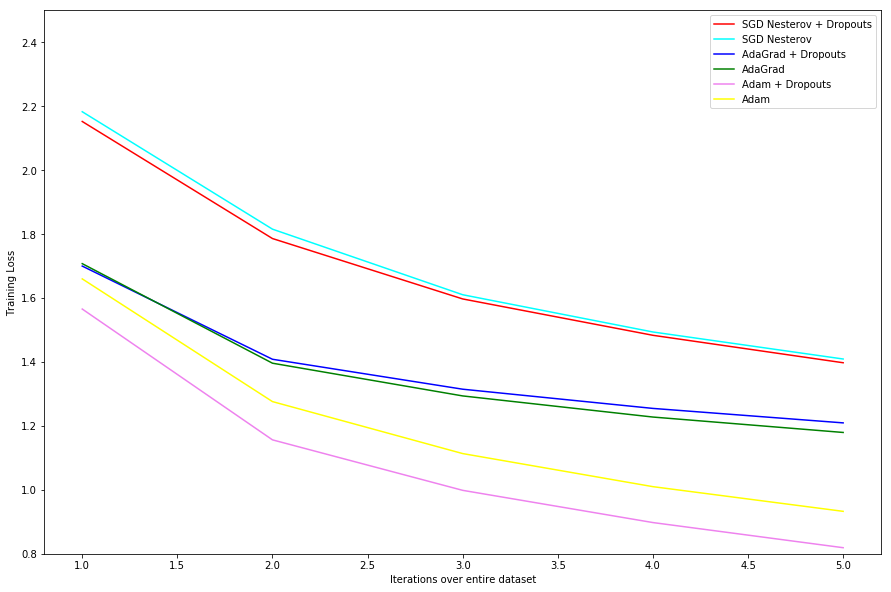

In [20]:
import matplotlib.pyplot as plt

x_axis = numpy.array(list(range(1,n_epochs+1)))
fig = plt.figure(figsize=(15,10))
plt.plot(x_axis, loss_sgdNesterov_dropout, color='red', label='SGD Nesterov + Dropouts')
plt.plot(x_axis, loss_sgdNesterov, color='cyan', label='SGD Nesterov')
plt.plot(x_axis, loss_adagrad_dropout, color='blue', label='AdaGrad + Dropouts')
plt.plot(x_axis, loss_adagrad, color='green', label='AdaGrad')
plt.plot(x_axis, loss_adam_dropout, color='violet', label='Adam + Dropouts')
plt.plot(x_axis, loss_adam, color='yellow', label='Adam')
plt.legend(loc=1)
plt.ylim(0.8,2.5)
plt.xlabel('Iterations over entire dataset')
plt.ylabel('Training Loss')
plt.show()

**Plot for accuracies.**

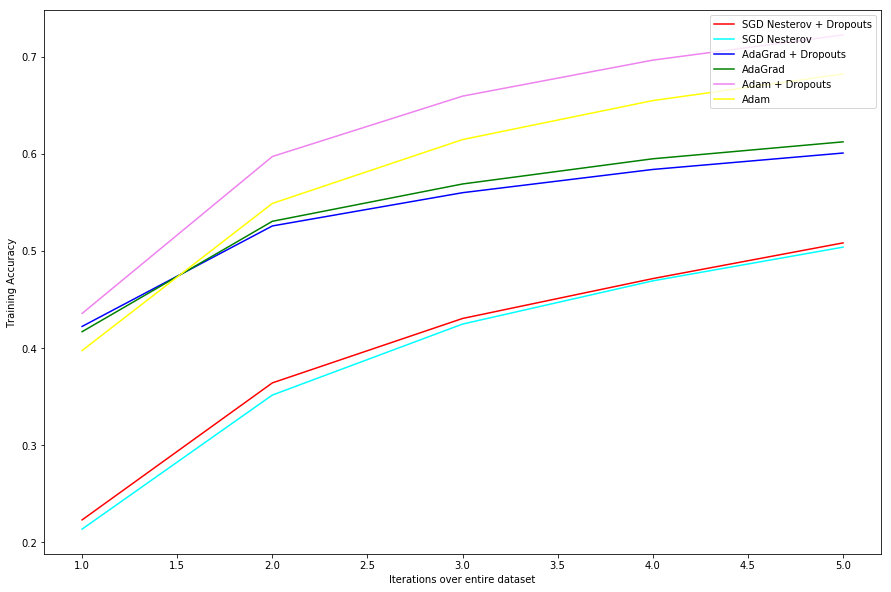

In [18]:
x_axis = numpy.array(list(range(1,n_epochs+1)))
fig = plt.figure(figsize=(15,10))
plt.plot(x_axis, accuracy_sgdNesterov_dropout, color='red', label='SGD Nesterov + Dropouts')
plt.plot(x_axis, accuracy_sgdNesterov, color='cyan', label='SGD Nesterov')
plt.plot(x_axis, accuracy_adagrad_dropout, color='blue', label='AdaGrad + Dropouts')
plt.plot(x_axis, accuracy_adagrad, color='green', label='AdaGrad')
plt.plot(x_axis, accuracy_adam_dropout, color='violet', label='Adam + Dropouts')
plt.plot(x_axis, accuracy_adam, color='yellow', label='Adam')
plt.legend(loc=1)
plt.xlabel('Iterations over entire dataset')
plt.ylabel('Training Accuracy')
plt.show()

# **The results and findings are discussed in the PDF.**